# AMS Classifier

This project was completed as my thesis project. The aim of this project is to predict wether a student would be categorized as AMS using ML model. AMS stands for 'Akhir Masa Studi', a label for student that need more than 11 semester to complete their study. We'll use two supervised ML model which is `k-Nearest Neighbor` and `Logistic Regression` to compare which model has better performance.<br><br>
The data used in this project acquired from the Pasundan University Faculty of Engineering's academic database

<hr>

Let's start with importing the necessary libraries

In [1]:
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, accuracy_score, fbeta_score, roc_auc_score
from sklearn.decomposition import IncrementalPCA
from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours, NeighbourhoodCleaningRule
from imblearn.over_sampling import SMOTE
import math
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

# 

### Function Declaration

In [3]:
def visualization_func(X, y):
    X = pd.DataFrame(X, columns=['p1', 'p2'])

    X['AMS'] = y

    X_ams = X[X['AMS'] == 1]
    X_nams = X[X['AMS'] == 0]

    X_ams.drop(['AMS'], axis=1, inplace=True)
    X_nams.drop(['AMS'], axis=1, inplace=True)
    
    X_ams = X_ams.to_numpy()
    X_nams = X_nams.to_numpy()
    
    plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(X_ams[:,0], X_ams[:,1], c = 'yellow', edgecolors='k', label="AMS")
    plt.scatter(X_nams[:,0], X_nams[:,1], c = 'red', edgecolors='k', label='Non-AMS')
    plt.xlabel('1st Principal Component')
    plt.ylabel('2nd Principal Component')
    plt.title('Training Set Scatter Plot with labels')
    plt.legend()

In [4]:
def tr_te_visualization_func(Xtr, Xte, ytr, yte, sem):
    Xtr = pd.DataFrame(Xtr, columns=['p1', 'p2'])
    Xte = pd.DataFrame(Xte, columns=['p1', 'p2'])

    Xtr['AMS'], Xte['AMS'] = ytr, yte

    Xtr_ams, Xtr_nams = Xtr[Xtr['AMS'] == 1], Xtr[Xtr['AMS'] == 0]
    Xte_ams, Xte_nams = Xte[Xte['AMS'] == 1], Xte[Xte['AMS'] == 0]

    Xtr_ams.drop(['AMS'], axis=1, inplace=True)
    Xtr_nams.drop(['AMS'], axis=1, inplace=True)
    Xte_ams.drop(['AMS'], axis=1, inplace=True)
    Xte_nams.drop(['AMS'], axis=1, inplace=True)
    
    Xtr_ams, Xtr_nams = Xtr_ams.to_numpy(), Xtr_nams.to_numpy()
    Xte_ams, Xte_nams = Xte_ams.to_numpy(), Xte_nams.to_numpy()
       
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0)
    #fig.suptitle('Training Set Individual Class Scatter Plot', y=0.95)
    fig.supxlabel('1st Principal Component')
    fig.supylabel('2nd Principal Component', x=0.09)
    

    ax[0].scatter(Xtr_nams[:,0], Xtr_nams[:,1], edgecolor='k', c='red', label='Non-AMS', zorder=3)
    ax[0].scatter(Xtr_ams[:,0], Xtr_ams[:,1], edgecolor='k', c='yellow', label='AMS', zorder=3)
    ax[0].grid(zorder=0, linewidth='.5')
    ax[0].set_title(sem+' Train Scatter Plot')

    ax[1].scatter(Xte_nams[:,0], Xte_nams[:,1], edgecolor='k', c='red', label='Non-AMS', zorder=3)
    ax[1].scatter(Xte_ams[:,0], Xte_ams[:,1], edgecolor='k', c='yellow', label='AMS', zorder=3)
    ax[1].grid(zorder=0, linewidth='.5')
    ax[1].set_title(sem+' Test Scatter Plot')
    ax[1].legend(loc='upper center', bbox_to_anchor=(0, .9), shadow=True)

    plt.show()

In [5]:
score_name = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score']

In [6]:
def logres_default_validation_func(X_trsm, y_trsm, sem):

    log_score_sc = cross_validate(log_pipe, X_trsm, y_trsm, cv=10, scoring=scoring)
        
    score = []
    score.append(sem)
    for i in score_name:
        score.append('{:.4f}'.format(log_score_sc[i].mean()))
        
    return score

In [7]:
def logres_hyparam_tuning_func(X_trsm, y_trsm, scoring, sem):
    log_pipe = Pipeline([('logres', LogisticRegression())])
    log_params = [{'logres__max_iter' : [500, 1000, 5000],
                   'logres__C' : [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}]
    grid_log = GridSearchCV(log_pipe, param_grid=log_params, cv=10, scoring=scoring)
    
    grid_log.fit(X_trsm, y_trsm)
      
    hparam = []
    hparam.append(sem)
    for i in grid_log.best_params_.keys():
        hparam.append(grid_log.best_params_[i])
    hparam.append('{:.3f}'.format(grid_log.best_score_))
    
    return hparam

In [8]:
def logres_fit_hyparam_func(X_trsm, y_trsm, C, max_iter, sem):
    log_pipe = Pipeline([('logres', LogisticRegression(C=C, max_iter=max_iter))])

    log_score_sc = cross_validate(log_pipe, X_trsm, y_trsm, cv=10, scoring=scoring)
        
    score = []
    score.append(sem)
    for i in score_name:
        score.append('{:.4f}'.format(log_score_sc[i].mean()))
    
    return score

In [9]:
def knn_default_validation_func(X_trsm, y_trsm, sem):
    knn_scores = cross_validate(knn_pipe, X_trsm, y_trsm, cv=10, scoring=scoring)
    
    score = []
    score.append(sem)
    for i in score_name:
        score.append('{:.4f}'.format(knn_scores[i].mean()))
        
    return score

In [10]:
def knn_hyparam_tuning_func(X_trsm, y_trsm, score, sem):
    param_grid = dict(knn__n_neighbors=k_range, knn__weights=weight_options)
    pipe = Pipeline([('knn', KNeighborsClassifier())])
    grid_knn = GridSearchCV(pipe, param_grid, cv=10, scoring=score)
    
    grid_knn.fit(X_trsm, y_trsm)
    
    hparam = []
    hparam.append(sem)
    for i in grid_knn.best_params_.keys():
        hparam.append(grid_knn.best_params_[i])
    hparam.append('{:.3f}'.format(grid_knn.best_score_))
    
    return hparam

In [11]:
def knn_fit_hyparam_func(X_trsm, y_trsm, n_neighbors, weights, sem):
    pipe = Pipeline([('knn', KNeighborsClassifier(n_neighbors = n_neighbors, weights=weights))])

    knn_scores = cross_validate(pipe, X_trsm, y_trsm, cv=10, scoring=scoring)

    score = []
    score.append(sem)
    for i in score_name:
        score.append('{:.4f}'.format(knn_scores[i].mean()))
    
    return score

In [12]:
def test_score_func(model, X_te, y_te, sem):
    res=model.predict(X_te)
        
    result = []
    result.append(sem)
    result.append('{:.4f}'.format(accuracy_score(y_te, res)))
    result.append('{:.4f}'.format(precision_score(y_te, res)))
    result.append('{:.4f}'.format(recall_score(y_te, res)))
    result.append('{:.4f}'.format(f1_score(y_te, res)))
    
    return result

# 

# 

### Exploring the Data

In [13]:
dsm = pd.read_csv('Datasets/tidy_khs_plus_presensi.csv')

In [14]:
dsm.drop(['MhswID'], axis=1, inplace=True)

In [15]:
dsm.sample(5)

,IPS1,IPS2,IPS3,IPS4,IPS5,IPS6,IPS7,IPS8,SKS1,SKS2,SKS3,SKS4,SKS5,SKS6,SKS7,SKS8,P1,P2,P3,P4,P5,P6,P7,P8,AMS
689,3.68,3.68,3.23,3.91,3.52,3.88,3.83,4.00,19,38,58,81,99,116,139,146,0.00,0.00,94.31,91.38,91.25,97.14,0.00,0.00,0
1125,2.27,2.00,2.06,1.67,1.86,2.33,2.00,1.77,10,22,38,49,62,75,98,111,84.35,66.87,79.07,81.88,0.00,0.00,0.00,0.00,1
450,2.79,3.16,3.25,3.14,3.43,3.58,3.14,4.00,16,33,54,72,99,118,135,146,0.00,0.00,98.21,93.02,93.33,89.81,0.00,0.00,0
1907,3.45,3.11,3.30,3.50,3.41,3.27,3.20,3.00,31,50,67,85,108,121,136,138,100.00,99.59,0.00,0.00,98.04,96.19,100.00,0.00,0
249,2.17,2.56,3.05,2.25,3.41,2.69,3.00,3.22,11,25,51,63,84,100,117,126,0.00,0.00,0.00,0.00,89.22,79.70,79.26,70.24,0


In [87]:
print('Number of Columns: ', dsm.shape[1])
print('Number of Records: ', dsm.shape[0])

Number of Columns:  25
Number of Records:  3162


&emsp;&emsp; From the sample data above we can see there are 25 feature columns in total, 24 are input variables and 1 output (target) variable. The output is `AMS` column, and the rest are the inputs. The `IPS` columns are representing GPA in a particular semester. `SKS` columns are the sum of semester credit completed up to the indicated semester. `P` columns are the mean of student attendance in a particular semester. The number (1 to 8) in every columns indicating the semester number.<br>
&emsp;&emsp; `AMS` columns, stands for Akhir Masa Studi, is the target variable. Student that need more than 11 semester to complete their study classified as 1 or positive class, otherwise, 0 or negative class.

#### 

#### Drop Presensi Data

&emsp;&emsp; Take a look at the sample data, it's easy to notice a bunch of 0s (missing value) in the `P` feature columns. We want to know how many are the 0s exist in the dataset as it require different approach to solve the problem depending to the amount of the missing value.

In [105]:
dim_value = []
for i in dsm.columns[16:24]:
    dim_value.append((dsm[i].values == 0).sum())

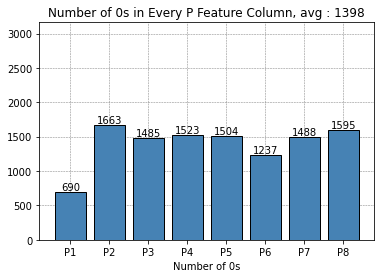

In [106]:
#Visualize number of 0s in P feature columns

fig = plt.Figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
dimension = dsm.columns[16:24]
plt.bar(dimension, dim_value, zorder=2, color='steelblue', edgecolor='black')
plt.xlabel('Number of 0s')
plt.title('Number of 0s in Every P Feature Column, avg : '+str(mean(dim_value)))
plt.grid(linestyle='--', linewidth=0.5, color='gray', zorder=0)
plt.ylim(0, dsm.shape[0])
for i in range(len(dimension)):
    plt.text(i, dim_value[i], dim_value[i], ha='center', va='bottom')

plt.show()

&emsp;&emsp; As we can see from the visualization above, there are **A LOT** of missing value from the `P` feature column. With 1398 average missing value from each `P` column, a reasonable course of action would be dropping all the `P` feature column.

In [19]:
(dsm[dsm.columns[16:24]].values == 0).sum()

11185

In [20]:
# Create new pandas dataframe

X_data = dsm.iloc[:, :-9] #input variables excluding P columns and output variable
y_data = dsm['AMS'] #output variable

In [21]:
X_data.head()

,IPS1,IPS2,IPS3,IPS4,IPS5,IPS6,IPS7,IPS8,SKS1,SKS2,SKS3,SKS4,SKS5,SKS6,SKS7,SKS8
0,3.15,2.53,2.16,2.48,2.75,2.63,2.69,1.80,17,31,44,62,81,97,119,123
1,1.82,3.18,3.67,3.55,4.00,3.57,4.00,4.00,55,74,101,121,129,136,138,142
2,2.54,2.74,1.83,2.67,2.50,2.57,2.43,2.00,23,42,52,70,88,102,112,122
3,3.75,3.53,3.25,4.00,3.55,3.36,3.67,2.86,20,39,59,78,98,120,135,139
4,3.15,2.95,3.10,2.84,3.00,3.10,3.00,3.00,17,33,50,69,95,115,130,140


### 

### Preparing the Data

&emsp;&emsp;We want to know how the model classify positive class from negative one. One way to find out is through **Decision Boundary**, a visualization showing thin surface dividing vector space into two or more region, one for each class. Data point that falls into a region classified into the class in which the region belong. To effectively display how the model works using decision boundary we need to reduce the dimension (feature column) in the dataset as it is hard to create scatter plot of data that has more than two features.<br><br>&emsp;&emsp;This can be done by using dimensionality reduction algorithm, one popular algorithm is **Principal Component Analisys**. PCA is affected by data scale, so we need to scale the features in the data before implementing PCA, this can be done by `StandardScaler` function to standardize the dataset’s features onto unit scale

#### Scale the Data

In [22]:
stdx = StandardScaler()
X_sc = stdx.fit_transform(X_data)
X_sc = pd.DataFrame(X_sc, columns=X_data.columns)
X_sc.head()

,IPS1,IPS2,IPS3,IPS4,IPS5,IPS6,IPS7,IPS8,SKS1,SKS2,SKS3,SKS4,SKS5,SKS6,SKS7,SKS8
0,0.260334,-1.201233,-1.526388,-1.060637,-0.682509,-1.024363,-0.990619,-2.610546,-0.048420,-0.411416,-1.036729,-0.700799,-0.817486,-0.765925,-0.539904,-0.949764
1,-2.464867,0.101476,1.350972,1.083745,1.798264,0.768141,1.505373,0.983843,8.251013,6.480124,5.686323,4.424641,2.642296,1.675461,0.781333,0.549958
2,-0.989571,-0.780358,-2.155215,-0.679859,-1.178664,-1.138779,-1.486006,-2.283783,1.262017,1.351536,-0.093143,-0.005824,-0.312934,-0.452927,-1.026676,-1.028697
3,1.489748,0.802935,0.550647,1.985588,0.905186,0.367688,0.876612,-0.878704,0.606799,0.870731,0.732495,0.689151,0.407854,0.673867,0.572717,0.313160
4,0.260334,-0.359482,0.264817,-0.339162,-0.186355,-0.128111,-0.399964,-0.649970,-0.048420,-0.090880,-0.329039,-0.092696,0.191617,0.360869,0.225022,0.392092


###### 

#### Split data by semester then add to dictionary

We want to test if the model have a good performance using dataset with reduced feature, so we copy the dataset into multiple dataset with reduced feature each. `data['S4']` contain all the feature up to fourth semester, `data['S5']` contain all the feature up to fifth semester, and so on.

In [23]:
data = {}
data['S8'] = X_sc
data['S7'] = X_sc.drop(['SKS8', 'IPS8'], axis=1)
data['S6'] = data['S7'].drop(['SKS7', 'IPS7'], axis=1)
data['S5'] = data['S6'].drop(['SKS6', 'IPS6'], axis=1)
data['S4'] = data['S5'].drop(['SKS5', 'IPS5'], axis=1)

In [24]:
data['S4'].head()

,IPS1,IPS2,IPS3,IPS4,SKS1,SKS2,SKS3,SKS4
0,0.260334,-1.201233,-1.526388,-1.060637,-0.048420,-0.411416,-1.036729,-0.700799
1,-2.464867,0.101476,1.350972,1.083745,8.251013,6.480124,5.686323,4.424641
2,-0.989571,-0.780358,-2.155215,-0.679859,1.262017,1.351536,-0.093143,-0.005824
3,1.489748,0.802935,0.550647,1.985588,0.606799,0.870731,0.732495,0.689151
4,0.260334,-0.359482,0.264817,-0.339162,-0.048420,-0.090880,-0.329039,-0.092696


###### 

#### Implement PCA

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(data['S8'])
pca.explained_variance_ratio_.sum()

0.7445441848093726

After applying dimensionality reduction we managed to keep 74% information in the dataset

In [86]:
pca = PCA(n_components = 2)

for i in range(8, 3, -1):
    x = str(i)
    data['S'+x] = pca.fit_transform(data['S'+x])

Here's how the data looked like after applying PCA

In [76]:
dfpca = pd.DataFrame(data['S8'], columns=['1st Principal Component', '2nd Principal Component'])
dfpca.head()

,1st Principal Component,2nd Principal Component
0,3.526379,1.043805
1,-8.003197,9.175006
2,2.926015,3.307850
3,-2.731683,0.411427
4,0.157554,0.164915


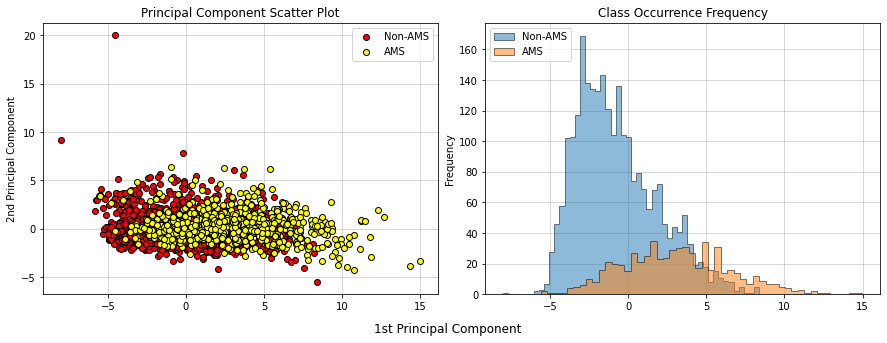

In [28]:
X = pd.DataFrame(data['S8'], columns=['a', 'b'])
X['y'] = y_data

X_ams = X[X['y'] == 1]
X_nams = X[X['y'] == 0]

X_ams.drop(['y'], axis=1, inplace=True)
X_nams.drop(['y'], axis=1, inplace=True)

X_ams = X_ams.to_numpy()
X_nams = X_nams.to_numpy()

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=False)
fig.subplots_adjust(wspace=.12)
#fig.suptitle('Training Set Individual Class Scatter Plot', y=0.95)
fig.supxlabel('1st Principal Component')

ax[0].scatter(X_nams[:,0], X_nams[:,1], edgecolor='k', c='red', label='Non-AMS', zorder=3)
ax[0].scatter(X_ams[:,0], X_ams[:,1], edgecolor='k', c='yellow', label='AMS', zorder=3)
ax[0].set_ylabel('2nd Principal Component')
ax[0].grid(zorder=0, linewidth='.5')
ax[0].set_title('Principal Component Scatter Plot')
ax[0].legend()

ax[1].hist(X_nams[:,0], bins=50, edgecolor='k', alpha=.5, label='Non-AMS', zorder=3, histtype='stepfilled')
ax[1].hist(X_ams[:,0], bins=50, edgecolor='k', alpha=.5, label='AMS', zorder=3, histtype='stepfilled')
ax[1].set_ylabel('Frequency')
ax[1].grid(zorder=0, linewidth='.5')
ax[1].set_title('Class Occurrence Frequency')
ax[1].legend(loc='upper left')

plt.show()

&emsp;&emsp;From the scatter plot shown above we can see that the data points from each class overlapping each other. If we were to draw a line dividing the region belong to each class, that would be a difficult task to do since we can't decide which class belong to which region. We can draw a conclusion that the data we have is quite uninformative or in other words, **we need more data**. But this is all the data we have, we'll see what we can do with it.<br><br>
&emsp;&emsp;From the histogram on the right we can conclude that the distribution of class in the dataset is uneven, there are more negative class than the positive one. So it's safe for us to say that we have an imbalanced dataset. Both problem stated above can be solved with sampling method, spesifically, Hybrid Sampling method. Combining Oversampling and Undersampling method, we solve imbalanced dataset problem by oversampling the positive class then undersampling the whole dataset to reduce the overlapping data points to better distinguish the separation between class.

#### Split Train Test

Before we applying the sampling method to the dataset, first we need to split the dataset into train and test set. We only apply the sampling method to the train set since we need the test set to really representing real world data so we can't apply any change to the set.

In [29]:
for i in range(4,9):
    x = str(i)
    data['Xtr'+x], data['Xte'+x], data['ytr'+x], data['yte'+x] = train_test_split(data['S'+x], y_data, 
                                                                                  test_size=0.2, random_state=1234)

In [30]:
print('Train size :', len(data['ytr8']))
print('Test size :', len(data['yte8']))

Train size : 2529
Test size : 633


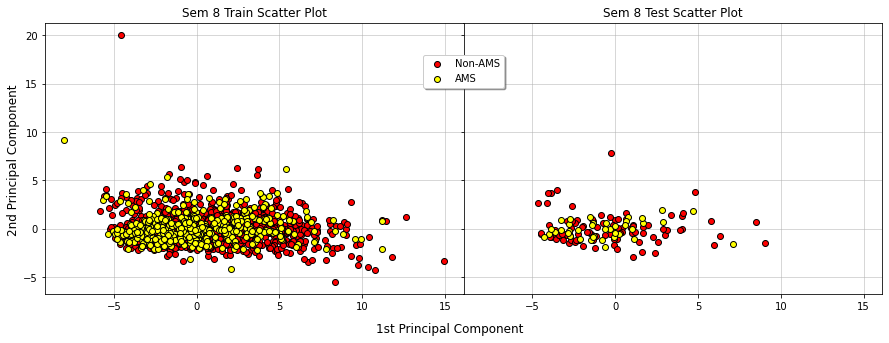

In [31]:
tr_te_visualization_func(data['Xtr8'], data['Xte8'], data['ytr8'], data['yte8'], 'Sem 8')

#### Implement SMOTEENN on training data

SMOTEENN is a hybrid sampling method combining SMOTE, an oversampling method, and ENN, undersampling method.

In [32]:
counter = Counter(data['ytr8'])
print('Before SMOTEENN :', counter)

Before SMOTEENN : Counter({0: 2026, 1: 503})


In [33]:
smotetm = SMOTEENN()

for i in range(4, 9):
    x = str(i)
    data['Xtrsm'+x], data['ytrsm'+x] = smotetm.fit_resample(data['Xtr'+x], data['ytr'+x])

#### Save SMOTEENN processed data to file - Skip to Load if data already saved as file

In [34]:
for i in range(8, 3, -1):
    x = str(i)
    pd.concat([pd.DataFrame(data['Xtrsm'+x]), pd.DataFrame(data['ytrsm'+x])],
          axis=1).to_csv('Datasets/SMOTEENN/trsm'+x+'.csv', index=False)

#### Load SMOTEENN processed data from file

In [35]:
for i in range(4,9):
    x = str(i)
    data['Xtrsm'+x] = pd.read_csv('Datasets/SMOTEENN/trsm'+x+'.csv', usecols=['0', '1']).to_numpy()
    data['ytrsm'+x] = pd.read_csv('Datasets/SMOTEENN/trsm'+x+'.csv', usecols=['AMS']).squeeze()


In [36]:
counter = Counter(data['ytrsm8'])
print('After SMOTEENN :', counter)

After SMOTEENN : Counter({1: 1215, 0: 1126})


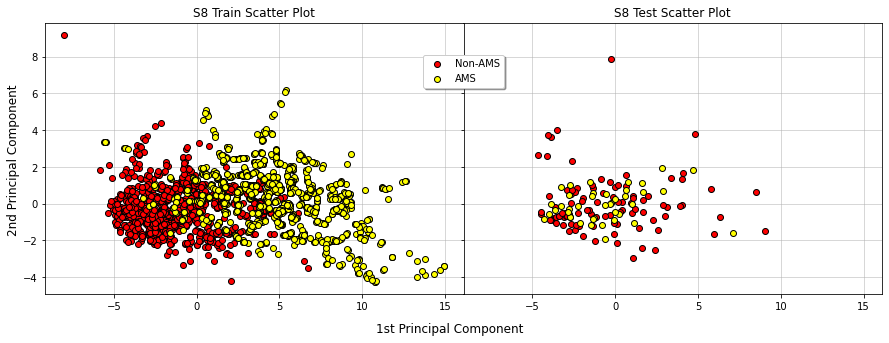

In [37]:
tr_te_visualization_func(data['Xtrsm8'], data['Xte8'], data['ytrsm8'], data['yte8'], 'S8')

After applying SMOTEENN we can see significant change in class ratio. Other than that we can see in the left scatter plot that there is more clear separation between classes.

<hr>

### Training the Models

#### Default Config Logistic Regression

In [38]:
scoring = {'accuracy' : make_scorer(accuracy_score),
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'f1_score' : make_scorer(f1_score)}

In [39]:
log_pipe = Pipeline([('logres', LogisticRegression())])

logsc = []
for i in range(8, 3, -1):
    x = str(i)
    logsc.append(logres_default_validation_func(data['Xtrsm'+x], data['ytrsm'+x], 'S'+x))

logsc = pd.DataFrame(logsc, columns=['Sem','Acc', 'Pre', 'Rec', 'F1'])
logsc.to_csv('Datasets/Result/def-val-logres.csv')

Here we can see the validation results of each dataset using Logistic Regression with default config

In [40]:
logsc

,Sem,Acc,Pre,Rec,F1
0,S8,0.8885,0.8937,0.8921,0.8926
1,S7,0.8853,0.8941,0.8890,0.8915
2,S6,0.8914,0.8860,0.9103,0.8978
3,S5,0.8790,0.8863,0.8900,0.8878
4,S4,0.8714,0.8701,0.8895,0.8789


#### Hyperparameter Tuning Logistic Regression

In [41]:
#oh = optimal hyperparameter
log_oh = []

for i in range(8, 3, -1):
    x = str(i)
    log_oh.append(logres_hyparam_tuning_func(data['Xtrsm'+x], data['ytrsm'+x], 'accuracy', 'S'+x))

log_oh = pd.DataFrame(log_oh, columns=['Sem', 'C', 'Max_iter', 'HiScore'])

In the dataframe below we can see the best combination of hyperparameter for each dataset

In [42]:
log_oh

,Sem,C,Max_iter,HiScore
0,S8,0.001,500,0.896
1,S7,0.100,500,0.887
2,S6,0.100,500,0.892
3,S5,0.100,500,0.880
4,S4,1.000,500,0.871


#### Fit optimal hyperparameter

In [43]:
# Fitted Hyperparameter Score
log_fhs = []

for i in range(4, 9):
    x = str(i)
    C, max_i = log_oh.iloc[i-4][1], log_oh.iloc[i-4][2]
    log_fhs.append(logres_fit_hyparam_func(data['Xtrsm'+x], data['ytrsm'+x], C, max_i, 'S'+x))

log_fhs = pd.DataFrame(log_fhs, columns=['Sem','Acc', 'Pre', 'Rec', 'F1'])
log_fhs.sort_values(by='Sem', ascending=False, inplace=True)
log_fhs.reset_index(drop=True, inplace=True)

Below is the validation result after fitting the optimal hyperparameter to the model

In [44]:
log_fhs

,Sem,Acc,Pre,Rec,F1
0,S8,0.8885,0.8937,0.8921,0.8926
1,S7,0.8873,0.8963,0.8906,0.8934
2,S6,0.8924,0.8875,0.9103,0.8986
3,S5,0.8803,0.8867,0.8926,0.8892
4,S4,0.8664,0.8659,0.8852,0.8747


The best dataset to use is Sem8 dataset, so we'll train the model using sem 8 dataset then we measure how the model perform using all dataset

#### Logistic Regression Test Score

In [45]:
model_log = LogisticRegression(C=0.001, max_iter=500).fit(data['Xtrsm8'], data['ytrsm8'])

log_tesc = [] # logistic regression test score

for i in range(8, 3, -1):
    x = str(i)
    log_tesc.append(test_score_func(model_log, data['Xte'+x], data['yte'+x], 'S'+x))

log_tesc = pd.DataFrame(log_tesc, columns=['Sem','Acc', 'Pre', 'Rec', 'F1'])

In the dataframe below we can see how our model perform to each dataset

In [46]:
log_tesc

,Sem,Acc,Pre,Rec,F1
0,S8,0.7551,0.3929,0.6814,0.4984
1,S7,0.7314,0.3596,0.6460,0.4620
2,S6,0.7346,0.3604,0.6283,0.4581
3,S5,0.7299,0.3550,0.6283,0.4537
4,S4,0.7299,0.3520,0.6106,0.4466


#### Visualizing Logistic Regression Decision Boundary

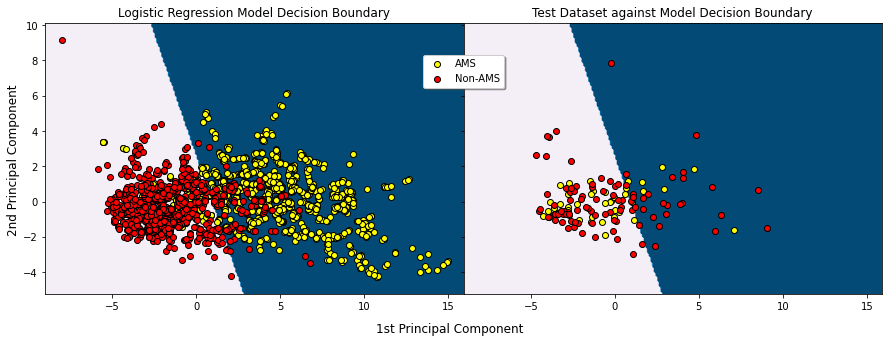

In [47]:
# plotting the decision boundary in the scatter plot of Training and Test Set with labels indicated by colors
X_trsm = data['Xtrsm8']
y_trsm = data['ytrsm8']

x_min, x_max = X_trsm[:, 0].min() - 1, X_trsm[:, 0].max() + 1
y_min, y_max = X_trsm[:, 1].min() - 1, X_trsm[:, 1].max() + 1

xx_train, yy_train = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                 np.arange(y_min, y_max, 0.1))

Z_train = model_log.predict(np.c_[xx_train.ravel(), yy_train.ravel()])
Z_train = Z_train.reshape(xx_train.shape)
########################################################################
X_te = data['Xte8']
y_te = data['yte8']

#x_min, x_max = X_te[:, 0].min() - 1, X_te[:, 0].max() + 1
#y_min, y_max = X_te[:, 1].min() - 1, X_te[:, 1].max() + 1

xx_test, yy_test = np.meshgrid(np.arange(x_min, x_max, 0.1),
                               np.arange(y_min, y_max, 0.1))

Z_test = model_log.predict(np.c_[xx_test.ravel(), yy_test.ravel()])
Z_test = Z_test.reshape(xx_test.shape)
#########################################################################



X_trsm = pd.DataFrame(X_trsm, columns=['a', 'b'])
X_trsm['y'] = y_trsm
X_te = pd.DataFrame(X_te, columns=['a', 'b'])
X_te['y'] = y_te

Xtr_ams = X_trsm[X_trsm['y'] == 1]
Xtr_nams = X_trsm[X_trsm['y'] == 0]
Xte_ams = X_te[X_te['y'] == 1]
Xte_nams = X_te[X_te['y'] == 0]

Xtr_ams.drop(['y'], axis=1, inplace=True)
Xtr_nams.drop(['y'], axis=1, inplace=True)
Xte_ams.drop(['y'], axis=1, inplace=True)
Xte_nams.drop(['y'], axis=1, inplace=True)

Xtr_ams = Xtr_ams.to_numpy()
Xtr_nams = Xtr_nams.to_numpy()
Xte_ams = Xte_ams.to_numpy()
Xte_nams = Xte_nams.to_numpy()


fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)
fig.supxlabel('1st Principal Component')
fig.supylabel('2nd Principal Component', x=0.09)

ax[0].contourf(xx_train, yy_train, Z_train, cmap='PuBu')
ax[0].scatter(Xtr_ams[:, 0], Xtr_ams[:, 1], c='yellow', edgecolor='k', label='AMS')
ax[0].scatter(Xtr_nams[:, 0], Xtr_nams[:, 1], c='red', edgecolor='k', label='Non-AMS')
ax[0].set_title('Logistic Regression Model Decision Boundary')


ax[1].contourf(xx_test, yy_test, Z_test, cmap='PuBu')
ax[1].scatter(Xte_ams[:, 0], Xte_ams[:, 1], c='yellow', edgecolor='k', label='AMS')
ax[1].scatter(Xte_nams[:, 0], Xte_nams[:, 1], c='red', edgecolor='k', label='Non-AMS')
ax[1].set_title('Test Dataset against Model Decision Boundary')
ax[1].legend(loc='upper center', bbox_to_anchor=(0, .9), shadow=True)
plt.savefig('logres_decision_boundary.png', bbox_inches='tight')
plt.show()


#### Default Config kNN

In [48]:
knn_pipe = Pipeline([('knn', KNeighborsClassifier())])

knnsc = []

for i in range(8, 3, -1):
    x = str(i)
    knnsc.append(knn_default_validation_func(data['Xtrsm'+x], data['ytrsm'+x], 'S'+x))
    
knnsc = pd.DataFrame(knnsc, columns=['Sem','Acc', 'Pre', 'Rec', 'F1'])

In [49]:
knnsc

,Sem,Acc,Pre,Rec,F1
0,S8,0.9658,0.9539,0.9819,0.9676
1,S7,0.9683,0.9618,0.9795,0.9705
2,S6,0.9638,0.9532,0.9793,0.9660
3,S5,0.9544,0.9493,0.9672,0.9580
4,S4,0.9594,0.9563,0.9675,0.9616


#### Hyperparameter Tuning kNN

In [50]:
k_range = range(1, 55)
weight_options = ['uniform', 'distance']

knn_oh = []

for i in range(8, 3, -1):
    x = str(i)
    knn_oh.append(knn_hyparam_tuning_func(data['Xtrsm'+x], data['ytrsm'+x], 'accuracy', 'S'+x))
    
knn_oh = pd.DataFrame(knn_oh, columns=['Sem','K', 'WeightOp', 'HiScore'])

&emsp;&emsp;The optimal combination of KNN hyperparameter is out, but for all the dataset, the optimal value for hyperparameter K is 1. That is actually make sense given the data we have. Take a look at how our data spread after we applied hybrid sampling. Most of the data points are placed very close with their neighbor data points. So that only make sense that the KNN algorithm would be picking 1 as the number of neighbor to take into consideration when classifying, since it would be correct most of the time. But we can't use 1 for our K because we would be overfitting the model, so we need another method to find an optimal K value.

In [51]:
knn_oh

,Sem,K,WeightOp,HiScore
0,S8,1,uniform,0.991
1,S7,1,uniform,0.991
2,S6,1,uniform,0.991
3,S5,1,uniform,0.987
4,S4,1,uniform,0.991


We're going to do a hyperparameter tuning using error rate

In [89]:
weightop = ['uniform', 'distance']
temp, res, a = [], [], []
error_rate = []
for x in range(4,9):
    for w in range(len(weightop)):
        for i in range(1,55):
            knn = KNeighborsClassifier(n_neighbors=i, weights=weightop[w])
            knn.fit(data['Xtrsm'+str(x)],data['ytrsm'+str(x)])
            pred_i = knn.predict(data['Xte'+str(x)])
            temp.append(np.mean(pred_i != data['yte'+str(x)]))
        error_rate.append(temp)
        er_i = len(error_rate)-1
        a.append('Sem'+str(x))
        a.append(weightop[w])
        a.append('{:.4f}'.format(min(error_rate[er_i])))
        a.append(error_rate[er_i].index(min(error_rate[er_i])) + 1)
        res.append(a)
        a = []
        temp = []


for i in range(0, 10, 2):
    if res[i][2] < res[i+1][2]:
        temp.append(res[i])
    else:
        temp.append(res[i+1])

temp, res = res, temp

In [90]:
temp

[['Sem4', 'uniform', '0.2749', 42],
 ['Sem4', 'distance', '0.2780', 54],
 ['Sem5', 'uniform', '0.2828', 2],
 ['Sem5', 'distance', '0.2844', 1],
 ['Sem6', 'uniform', '0.2701', 36],
 ['Sem6', 'distance', '0.2654', 45],
 ['Sem7', 'uniform', '0.2765', 54],
 ['Sem7', 'distance', '0.3033', 1],
 ['Sem8', 'uniform', '0.2622', 20],
 ['Sem8', 'distance', '0.2686', 37]]

In [91]:
res = pd.DataFrame(res, columns=['Dataset', 'WeightOp', 'ErrorRate', 'K'])
res.sort_values(by='ErrorRate', inplace=True)
res.reset_index(drop=True, inplace=True)

In [92]:
res

,Dataset,WeightOp,ErrorRate,K
0,Sem8,uniform,0.2622,20
1,Sem6,distance,0.2654,45
2,Sem4,uniform,0.2749,42
3,Sem7,uniform,0.2765,54
4,Sem5,uniform,0.2828,2


#### Visualizing Hyperparameter Tuning Process

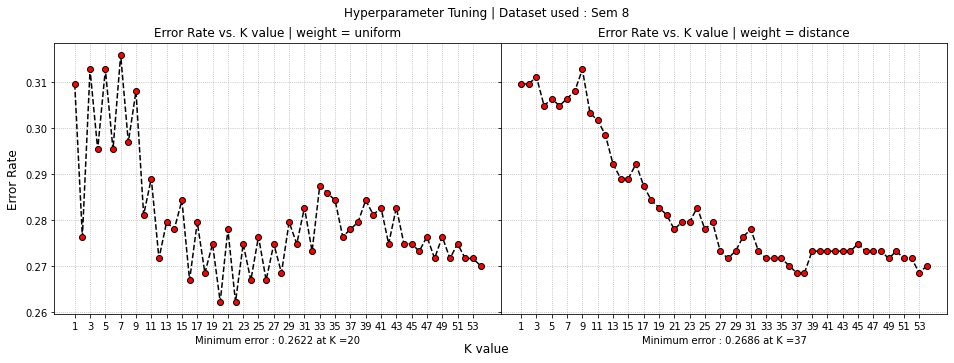

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(16,5), sharey=True)
fig.subplots_adjust(wspace=0)
fig.supxlabel('K value')
fig.supylabel('Error Rate', x=.084)
fig.suptitle('Hyperparameter Tuning | Dataset used : Sem 8')

ax[0].plot(range(1, 55), error_rate[8], marker='o', color='k', markerfacecolor='red', linestyle='--', zorder=3)
ax[0].grid(zorder=0, linestyle=':')
ax[0].set_xticks(np.arange(1, 55, 2))
ax[0].set_title('Error Rate vs. K value | weight = uniform')
ax[0].set_xlabel(('Minimum error : '+ str('{:.4f}'.format(min(error_rate[8])))+
                     ' at K ='+str(error_rate[8].index(min(error_rate[8])) + 1)))

ax[1].plot(range(1, 55), error_rate[9], marker='o', color='k', markerfacecolor='red', linestyle='--', zorder=3)
ax[1].grid(zorder=0, linestyle=':')
ax[1].set_xticks(np.arange(1, 55, 2))
ax[1].set_title('Error Rate vs. K value | weight = distance')
ax[1].set_xlabel(('Minimum error : '+ str('{:.4f}'.format(min(error_rate[9])))+
                     ' at K ='+str(error_rate[9].index(min(error_rate[9])) + 1)))

plt.show()

We can see the optimal combination of hyperparameter for the kNN algorithm

In [57]:
res

,Dataset,WeightOp,ErrorRate,K
0,Sem8,uniform,0.2622,20
1,Sem6,distance,0.2654,45
2,Sem4,uniform,0.2749,42
3,Sem7,uniform,0.2765,54
4,Sem5,uniform,0.2828,2


#### fit optimal parameter

In [70]:
knn_fhs = []

for i in range(4, 9):
    x = str(i)
    K, weight = res.iloc[i-4][3], res.iloc[i-4][1]
    knn_fhs.append(knn_fit_hyparam_func(data['Xtrsm'+x], data['ytrsm'+x], K, weight, 'S'+x))
    
knn_fhs = pd.DataFrame(knn_fhs, columns=['Sem','Acc', 'Pre', 'Rec', 'F1'])
knn_fhs.sort_values(by='Sem', ascending=False, inplace=True)
knn_fhs.reset_index(drop=True, inplace=True)

In [71]:
knn_fhs

,Sem,Acc,Pre,Rec,F1
0,S8,0.9872,0.9893,0.9860,0.9876
1,S7,0.9007,0.9031,0.9111,0.9069
2,S6,0.8942,0.8915,0.9094,0.9001
3,S5,0.9454,0.9348,0.9664,0.9502
4,S4,0.8903,0.9056,0.8844,0.8944


### kNN Test Score

In [60]:
model_knn = KNeighborsClassifier(n_neighbors=54, weights='uniform').fit(data['Xtrsm8'], data['ytrsm8'])
print('Model trained with sem 8 data')

knn_tesc = []

for i in range(8, 3, -1):
    x = str(i)
    knn_tesc.append(test_score_func(model_knn, data['Xte'+x], data['yte'+x], 'S'+x))
    
knn_tesc = pd.DataFrame(knn_tesc, columns=['Sem','Acc', 'Pre', 'Rec', 'F1'])

Model trained with sem 8 data


In [61]:
knn_tesc

,Sem,Acc,Pre,Rec,F1
0,S8,0.7299,0.3645,0.6903,0.4771
1,S7,0.7125,0.3467,0.6903,0.4615
2,S6,0.7062,0.3318,0.6372,0.4364
3,S5,0.7030,0.3288,0.6372,0.4337
4,S4,0.6967,0.3196,0.6195,0.4217


#### Visualizing kNN Decision Boundary

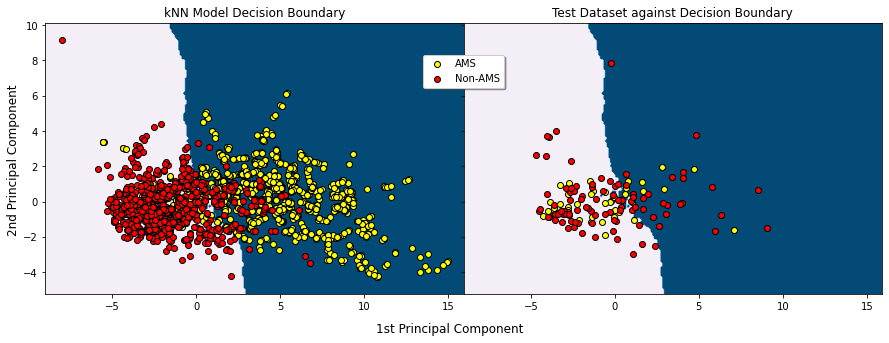

In [63]:
# plotting the decision boundary in the scatter plot of Training and Test Set with labels indicated by colors
X_trsm = data['Xtrsm8']
y_trsm = data['ytrsm8']

x_min, x_max = X_trsm[:, 0].min() - 1, X_trsm[:, 0].max() + 1
y_min, y_max = X_trsm[:, 1].min() - 1, X_trsm[:, 1].max() + 1

xx_train, yy_train = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                 np.arange(y_min, y_max, 0.1))

Z_train = model_knn.predict(np.c_[xx_train.ravel(), yy_train.ravel()])
Z_train = Z_train.reshape(xx_train.shape)
########################################################################
X_te = data['Xte8']
y_te = data['yte8']

#x_min, x_max = X_te[:, 0].min() - 1, X_te[:, 0].max() + 1
#y_min, y_max = X_te[:, 1].min() - 1, X_te[:, 1].max() + 1

xx_test, yy_test = np.meshgrid(np.arange(x_min, x_max, 0.1),
                               np.arange(y_min, y_max, 0.1))

Z_test = model_knn.predict(np.c_[xx_test.ravel(), yy_test.ravel()])
Z_test = Z_test.reshape(xx_test.shape)
#########################################################################



X_trsm = pd.DataFrame(X_trsm, columns=['a', 'b'])
X_trsm['y'] = y_trsm
X_te = pd.DataFrame(X_te, columns=['a', 'b'])
X_te['y'] = y_te

Xtr_ams = X_trsm[X_trsm['y'] == 1]
Xtr_nams = X_trsm[X_trsm['y'] == 0]
Xte_ams = X_te[X_te['y'] == 1]
Xte_nams = X_te[X_te['y'] == 0]

Xtr_ams.drop(['y'], axis=1, inplace=True)
Xtr_nams.drop(['y'], axis=1, inplace=True)
Xte_ams.drop(['y'], axis=1, inplace=True)
Xte_nams.drop(['y'], axis=1, inplace=True)

Xtr_ams = Xtr_ams.to_numpy()
Xtr_nams = Xtr_nams.to_numpy()
Xte_ams = Xte_ams.to_numpy()
Xte_nams = Xte_nams.to_numpy()


fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.supxlabel('1st Principal Component')
fig.supylabel('2nd Principal Component', x=0.09)

ax[0].contourf(xx_train, yy_train, Z_train, cmap='PuBu')
ax[0].scatter(Xtr_ams[:, 0], Xtr_ams[:, 1], c='yellow', edgecolor='k', label='AMS')
ax[0].scatter(Xtr_nams[:, 0], Xtr_nams[:, 1], c='red', edgecolor='k', label='Non-AMS')
ax[0].set_title('kNN Model Decision Boundary')

ax[1].contourf(xx_test, yy_test, Z_test, cmap='PuBu')
ax[1].scatter(Xte_ams[:, 0], Xte_ams[:, 1], c='yellow', edgecolor='k', label='AMS')
ax[1].scatter(Xte_nams[:, 0], Xte_nams[:, 1], c='red', edgecolor='k', label='Non-AMS')
ax[1].set_title('Test Dataset against Decision Boundary')
ax[1].legend(loc='upper center', bbox_to_anchor=(0, .9), shadow=True)


plt.show()

In [176]:
frames = [knn_tesc, log_tesc]
df_res = pd.concat(frames, keys=['kNearest Neighbor', 'Logistic Regression'], axis=1)

In [177]:
df_res

kNearest Neighbor                                 Logistic Regression  \
                Sem     Acc     Pre     Rec      F1                 Sem   
0                S8  0.7299  0.3645  0.6903  0.4771                  S8   
1                S7  0.7125  0.3467  0.6903  0.4615                  S7   
2                S6  0.7062  0.3318  0.6372  0.4364                  S6   
3                S5  0.7030  0.3288  0.6372  0.4337                  S5   
4                S4  0.6967  0.3196  0.6195  0.4217                  S4   

                                   
      Acc     Pre     Rec      F1  
0  0.7551  0.3929  0.6814  0.4984  
1  0.7314  0.3596  0.6460  0.4620  
2  0.7346  0.3604  0.6283  0.4581  
3  0.7299  0.3550  0.6283  0.4537  
4  0.7299  0.3520  0.6106  0.4466

From the table above we can see that generally Logistic Regression outperform kNN in predicting AMS by ~2-3% difference in every metrics.

# 